In [83]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
batch_size = 128

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=15)
     ]
)

training_set = torchvision.datasets.CIFAR10(root='./data',
                                            train=True,
                                            download=True,
                                            transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)
train_loader = torch.utils.data.DataLoader(training_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:04<00:00, 35227752.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
def n_imshow(n, data, classes):
  data_iter = iter(train_loader)
  imgs, labels = next(data_iter)

  fig, axes = plt.subplots(3,int(np.ceil(n/3)), figsize=(7,7))
  axes = axes.flatten()
  for i in range(n):
    img, label = imgs[i], labels[i]
    label_name = classes[label]
    ax = axes[i]
    np_img = (img*0.5+0.5).numpy()
    ax.imshow(np.transpose(np_img, (1,2,0)))
    ax.set_title(label_name)
  plt.tight_layout()
  plt.suptitle('Training Example Pictures')
  plt.show()

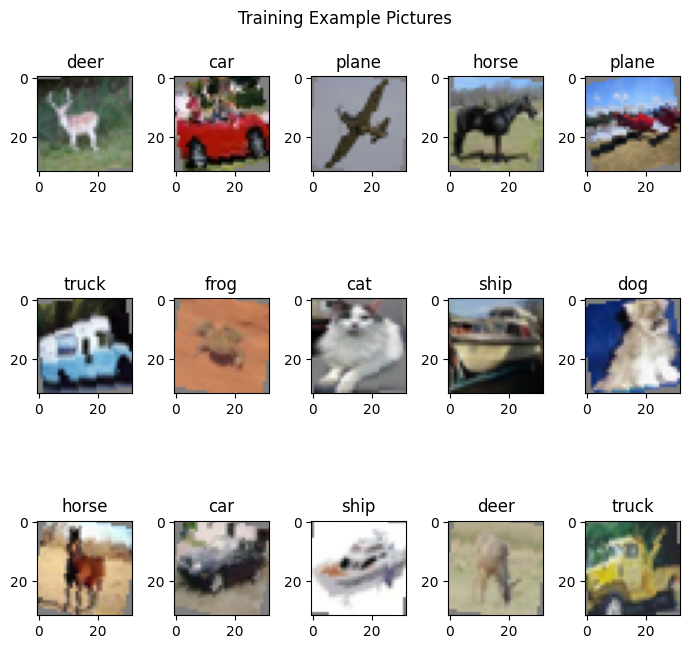

In [4]:
n_imshow(n=15, data=train_loader, classes=classes)

In [5]:
class ConvNetClassifier(nn.Module):
  def __init__(self):
    super(ConvNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) 
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.batchnorm3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0) 
    self.batchnorm4 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(in_features=6*6*64,out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=10)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.3)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.conv2(x))
    x = self.batchnorm2(x)
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.batchnorm3(x)
    x = F.relu(self.conv4(x))
    x = self.batchnorm4(x)
    x = self.pool(x)
    x = x.view(-1, 6*6*64)
    x = self.dropout1(x)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
ConvNetClf = ConvNetClassifier().to(device)


cuda:0


In [6]:
training_loss_history = []
training_accurates_history = []
validation_loss_history = []
validation_accurates_history = []

In [7]:
def train_model(epochs, learning_rate, pretrained_epochs=0):
  print("Training Started")
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(params=ConvNetClf.parameters(), lr = learning_rate)
  print(f"Learning Rate = {learning_rate}")
  for epoch in range(epochs):
    epoch_start = time.time()
    training_loss = 0.0
    training_accurates = 0.0
    validation_loss = 0.0
    validation_accurates = 0.0

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = ConvNetClf(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1)
      training_loss += loss.item()
      training_accurates += torch.sum(preds == labels.data)

    with torch.no_grad():
      for val_inputs, val_labels in test_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = ConvNetClf(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        validation_loss += val_loss.item()
        validation_accurates += torch.sum(val_preds == val_labels.data)

    epoch_loss = training_loss / (len(train_loader)*batch_size)
    epoch_accuracy = training_accurates.float() / (len(train_loader)*batch_size)
    training_loss_history.append(epoch_loss)
    training_accurates_history.append(epoch_accuracy.cpu().item())

    val_epoch_loss = validation_loss / (len(test_loader)*batch_size)
    val_epoch_accuracy = validation_accurates.float() / (len(test_loader)*batch_size)
    validation_loss_history.append(val_epoch_loss)
    validation_accurates_history.append(val_epoch_accuracy.cpu().item())
    epoch_end = time.time()
    if pretrained_epochs == 0:
      print(f'Epoch : {epoch+1} -- {round(epoch_end - epoch_start,2)} seconds --> Training Loss : {round(epoch_loss,4)} -- Training Accuracy : {epoch_accuracy} -- Validation Loss = {round(val_epoch_loss,4)} -- Validation Accuracy = {val_epoch_accuracy}')
    else:
      print(f'Epoch : {pretrained_epochs+epoch+1} -- {round(epoch_end - epoch_start,2)} seconds --> Training Loss : {round(epoch_loss,4)} -- Training Accuracy : {epoch_accuracy} -- Validation Loss = {round(val_epoch_loss,4)} -- Validation Accuracy = {val_epoch_accuracy}')

def plot_training_statistics(training_loss, validation_loss, training_accuracy, validation_accuracy):
  plt.style.use('ggplot')
  plt.figure(figsize=(8,4))
  plt.plot(training_loss_history, label='Training Loss')
  plt.plot(validation_loss_history, label='Validation Loss')
  plt.title('Training vs Validation Loss')
  plt.xlabel('Epoch-1')
  plt.legend()
  plt.show()

  plt.style.use('ggplot')
  plt.figure(figsize=(8,4))
  plt.plot(training_accurates_history, label='Training Accuracy')
  plt.plot(validation_accurates_history, label='Validation Accuracy')
  plt.title('Training vs Validation Accuracy')
  plt.xlabel('Epoch-1')
  plt.legend()
  plt.show()

Training Started
Learning Rate = 0.001
Epoch : 1 -- 45.38 seconds --> Training Loss : 0.0102 -- Training Accuracy : 0.5297914147377014 -- Validation Loss = 0.0084 -- Validation Accuracy = 0.6126384735107422
Epoch : 2 -- 38.99 seconds --> Training Loss : 0.0074 -- Training Accuracy : 0.6653812527656555 -- Validation Loss = 0.007 -- Validation Accuracy = 0.679094135761261
Epoch : 3 -- 39.31 seconds --> Training Loss : 0.0064 -- Training Accuracy : 0.713455080986023 -- Validation Loss = 0.0064 -- Validation Accuracy = 0.7112342119216919
Epoch : 4 -- 39.34 seconds --> Training Loss : 0.0058 -- Training Accuracy : 0.7402094006538391 -- Validation Loss = 0.0061 -- Validation Accuracy = 0.7218157052993774
Epoch : 5 -- 39.05 seconds --> Training Loss : 0.0054 -- Training Accuracy : 0.7582321166992188 -- Validation Loss = 0.006 -- Validation Accuracy = 0.734375
Epoch : 6 -- 39.83 seconds --> Training Loss : 0.0051 -- Training Accuracy : 0.7698609232902527 -- Validation Loss = 0.0057 -- Validati

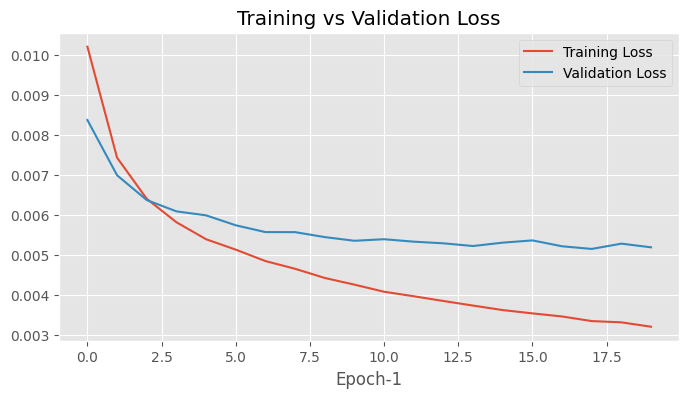

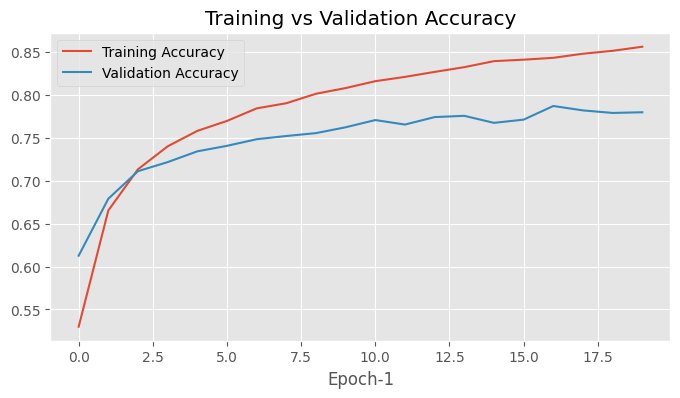

In [8]:
train_model(epochs=20, learning_rate=0.001)
plot_training_statistics(training_loss_history, validation_loss_history, training_accurates_history, validation_accurates_history)

Training Started
Learning Rate = 1e-05
Epoch : 1 -- 38.96 seconds --> Training Loss : 0.0029 -- Training Accuracy : 0.8689457774162292 -- Validation Loss = 0.0051 -- Validation Accuracy = 0.7855023741722107
Epoch : 2 -- 38.74 seconds --> Training Loss : 0.0028 -- Training Accuracy : 0.8743606209754944 -- Validation Loss = 0.0049 -- Validation Accuracy = 0.7915348410606384
Epoch : 3 -- 39.16 seconds --> Training Loss : 0.0027 -- Training Accuracy : 0.8749800324440002 -- Validation Loss = 0.005 -- Validation Accuracy = 0.7872824668884277
Epoch : 4 -- 39.66 seconds --> Training Loss : 0.0027 -- Training Accuracy : 0.8779571652412415 -- Validation Loss = 0.0049 -- Validation Accuracy = 0.7923259735107422
Epoch : 5 -- 39.61 seconds --> Training Loss : 0.0027 -- Training Accuracy : 0.8793358206748962 -- Validation Loss = 0.0048 -- Validation Accuracy = 0.7900514602661133
Epoch : 6 -- 38.9 seconds --> Training Loss : 0.0026 -- Training Accuracy : 0.8820332288742065 -- Validation Loss = 0.0048

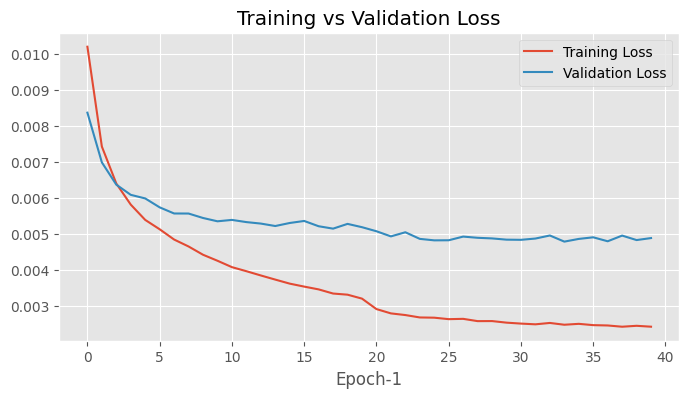

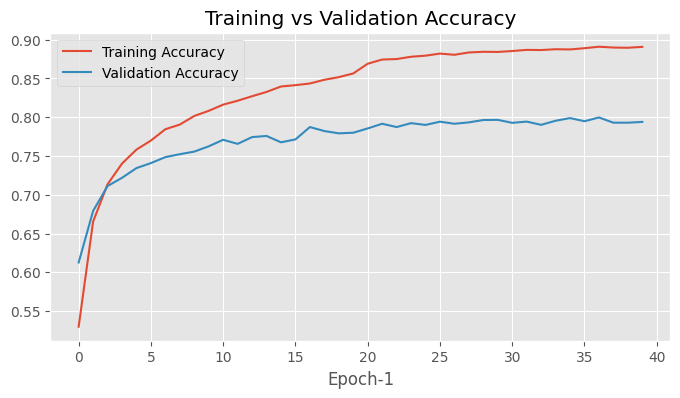

In [9]:
train_model(epochs=20, learning_rate=1.e-5)
plot_training_statistics(training_loss_history, validation_loss_history, training_accurates_history, validation_accurates_history)

Training Started
Learning Rate = 1e-06
Epoch : 1 -- 38.36 seconds --> Training Loss : 0.0024 -- Training Accuracy : 0.8903452754020691 -- Validation Loss = 0.0048 -- Validation Accuracy = 0.7933148741722107
Epoch : 2 -- 37.68 seconds --> Training Loss : 0.0024 -- Training Accuracy : 0.8916040658950806 -- Validation Loss = 0.0048 -- Validation Accuracy = 0.7956883311271667
Epoch : 3 -- 39.33 seconds --> Training Loss : 0.0024 -- Training Accuracy : 0.890684962272644 -- Validation Loss = 0.0049 -- Validation Accuracy = 0.7952927350997925
Epoch : 4 -- 37.7 seconds --> Training Loss : 0.0024 -- Training Accuracy : 0.8913642764091492 -- Validation Loss = 0.0048 -- Validation Accuracy = 0.8018196225166321
Epoch : 5 -- 37.89 seconds --> Training Loss : 0.0025 -- Training Accuracy : 0.8880274891853333 -- Validation Loss = 0.0048 -- Validation Accuracy = 0.7996439933776855
Epoch : 6 -- 38.37 seconds --> Training Loss : 0.0024 -- Training Accuracy : 0.8894661068916321 -- Validation Loss = 0.0047

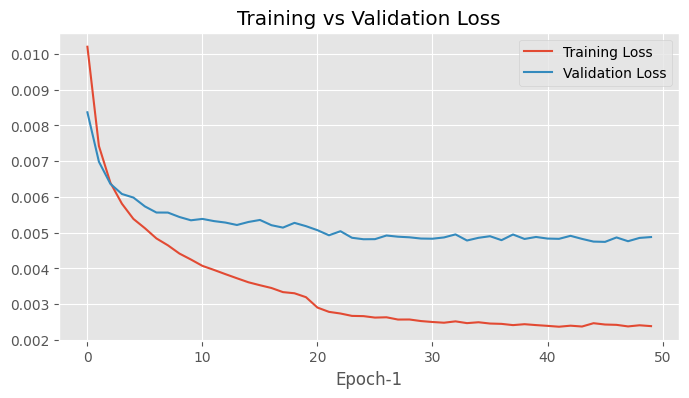

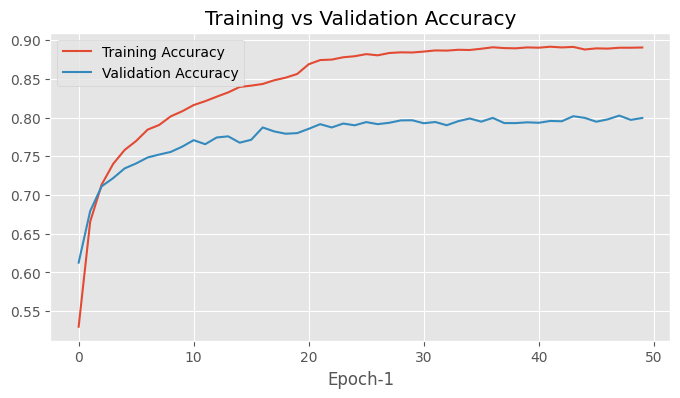

In [10]:
train_model(epochs=10, learning_rate=1.e-6)
plot_training_statistics(training_loss_history, validation_loss_history, training_accurates_history, validation_accurates_history)

In [22]:
import os
model_path = os.path.join(os.getcwd(), 'convnet_classifier.pth')
checkpoint = {
    'model_state_dict': ConvNetClf.state_dict(),
}
torch.save(checkpoint, model_path)

In [23]:
loaded_checkpoint = torch.load(model_path)
model = ConvNetClassifier()
model.load_state_dict(loaded_checkpoint['model_state_dict'])
model = model.to(device)

In [77]:
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    actual_labels = []
    for test_inputs, test_labels in test_loader:
        inputs = test_inputs.to(device)
        targets = test_labels.to(device)
        outputs = model(inputs)
        
        _, y_pred = torch.max(outputs, 1)
        correct += torch.sum(y_pred == targets)
        total += len(targets)
        predicted_labels.append(y_pred.cpu().numpy())
        actual_labels.append(targets.cpu().numpy())

predicted_labels = np.concatenate(predicted_labels)
actual_labels = np.concatenate(actual_labels)
print(f"Test Accuracy = {round(correct.cpu().item() / total, 4)*100}%")
print(f"{correct.cpu().item()} out of {total} observations classified correctly")

Test Accuracy = 80.27%
8027 out of 10000 observations classified correctly


In [84]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

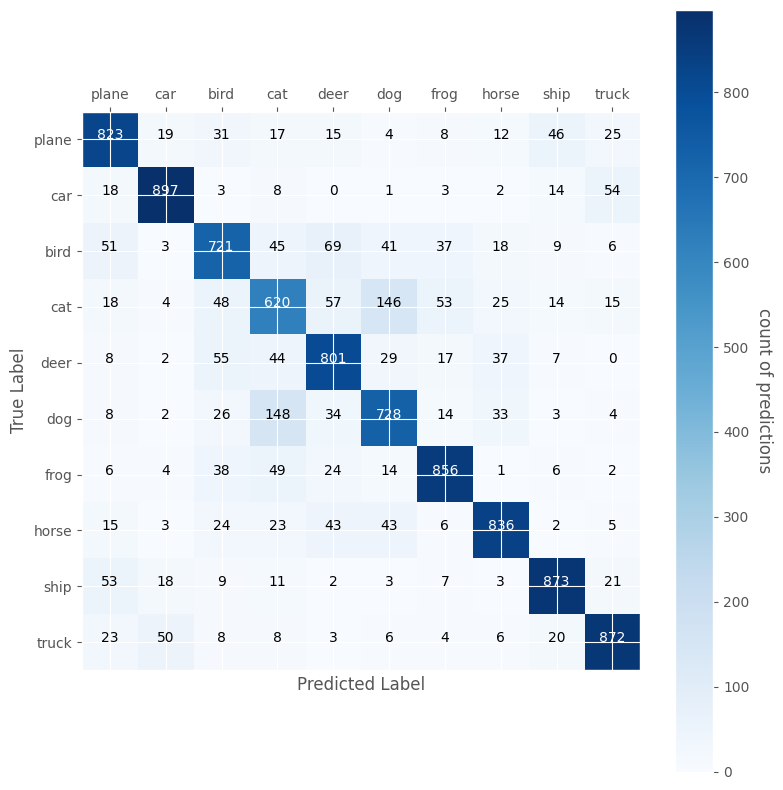

In [92]:
errors = (predicted_labels - actual_labels != 0)
false_prediction_classes = predicted_labels[errors]
cm = confusion_matrix(actual_labels, predicted_labels) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(cm, classes, classes, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()